# Neural Network Classification with TensorFlow

So far, we've only handled regression problems in TensorFlow, let's look at how we can approach a classification problem.

A classification problem essentially involves predicting whether something is one thing or another (predicting the class).

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether an image is of a cat, a person, or a dog. This is called **multi-class classification** since there are more than two classes.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned. We won't be covering this kind of classification.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

### What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (training it)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)

### Typical architecture of a classification neural network

The architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the programmer creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for cat, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

Table 1: Typical architecture of a classification network. Source: Adapted from "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" book by Aurélien Géron


In [1]:
import tensorflow as tf

2025-11-04 15:25:21.491401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-04 15:25:21.491472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-04 15:25:21.492286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-04 15:25:21.498669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our own classification data.
Note: It's a common practice to get you and model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).
Since classification is predicting whether something is one thing or another, let's make some data to reflect that.
To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.



In [2]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
# Check out the features
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Let's look at our data by creating a pandas DataFrame.

In [5]:
# Make dataframe of features and labels
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


What kind of labels are we dealing with?

In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

This shows us we're dealing with a **binary classification** problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called **multiclass classification**.

Let's take our visualization a step further and plot our data.

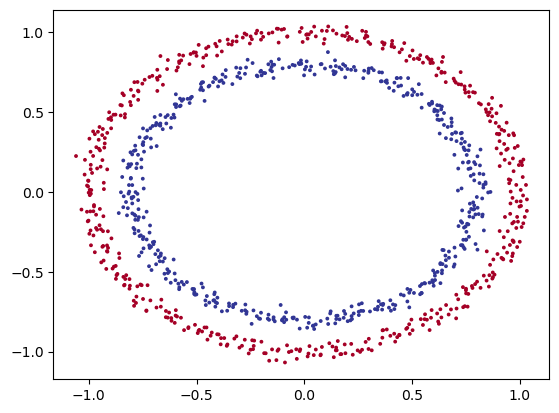

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, s = 3);

From the plot you can already tell which kind of classifier we would like to build. One that can predict, whether some coordinates belong to a blue or a red dot.

### Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.
More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.
So let's look at the shapes of `X` and `y`.

In [8]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

We seem to have 1000 data points, each with two coordinates and 1000 corresponding labels. In general terms we could also say, we have 1000 instances with two features each.

### Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

As you already know, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. **Fitting a model** - training the model to try and find patterns in the data (how does `X` get to `y`).

We will start with an overly simplified model and take it from there.

In [9]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=5)

2025-11-04 15:25:26.065987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


Epoch 1/5
32/32 [==============================] - 2s 2ms/step - loss: 3.3928 - accuracy: 0.4710
Epoch 2/5
 1/32 [..............................] - ETA: 0s - loss: 0.8732 - accuracy: 0.5000

2025-11-04 15:25:28.479446: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe544fbeaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 15:25:28.479501: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-11-04 15:25:28.493625: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1762266328.555145 1972059 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 0s 1ms/step - loss: 0.7604 - accuracy: 0.5000
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 0.7116 - accuracy: 0.4960
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.5050
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 0.6961 - accuracy: 0.5010


Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [10]:
# Train our model for longer (more chances to look at the data)
model_1.fit(X, y, epochs=200, verbose=0) # set verbose=0 to remove training updates
model_1.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5000


[0.6934829950332642, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What could we do to improve the model?

In [11]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0) # set verbose=0 to make the output print less

In [12]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5000


[0.6938093304634094, 0.5]

Still not even as good as guessing (~50% accuracy). 
Let's remind ourselves of a couple more ways we can use to improve our models.

### Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).


Any suggestions what we should do?

In [13]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=0) # fit for 100 passes of the data

2025-11-04 15:25:42.386612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


In [14]:
model_3.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5130


[0.6977073550224304, 0.5130000114440918]

Still no improvement.

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's goin on.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

In [15]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

313/313 [==============================] - 0s 657us/step
doing binary classifcation...


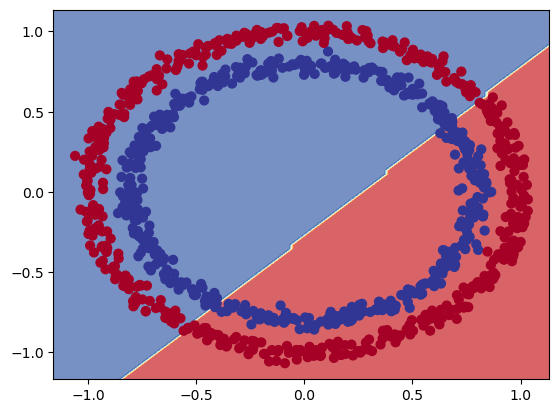

In [16]:
# Visualize the predictions our model is making
plot_decision_boundary(model_3, X, y)

Looks like our model is trying to draw a straight line through the data.
The main issue is our data isn't separable by a straight line.

### The missing piece: Non-linearity

We realized our neural network can create a linear separation, but we are faced with a non-linear classification problem.
If we're going to model our classification data properly, we're going to need some non-linearity.

>Before we get to the next steps, let's head to the playground. With that I mean the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

We'll try and replicate what we saw on the TensorFlow Playground.
The main change we'll add to models we've built before is the use of the `activation` keyword.

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 3.2493 - accuracy: 0.4650
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5862 - accuracy: 0.4670
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1100 - accuracy: 0.4590
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.0572 - accuracy: 0.4370
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 1.0159 - accuracy: 0.4180
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9814 - accuracy: 0.3850
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9435 - accuracy: 0.4110
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8991 - accuracy: 0.3960
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8702 - accuracy: 0.4110
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8451 - accuracy: 0.3760
Epoch 11/

In [18]:
# Evaluate the model
model_4.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.2982 - accuracy: 0.9680


[0.2982199788093567, 0.9679999947547913]

We're slowly getting to where we want to be, but our model is still far from perfect.
Let's visualize the predictions

313/313 [==============================] - 0s 653us/step
doing binary classifcation...


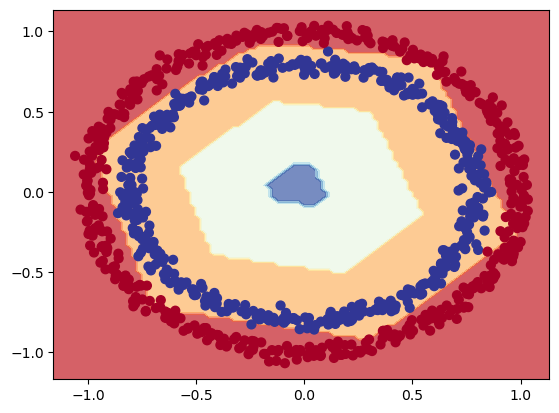

In [19]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_4, X, y)

To improve the model by a lot, we also need an activation function for the output layer.
Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [20]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_5.fit(X, y, epochs=100, verbose=0)

In [21]:
# Evaluate our model
model_5.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.4884 - accuracy: 0.8140


[0.4883947968482971, 0.8140000104904175]

Finally, our model is getting some good results. Let's visualize them.

313/313 [==============================] - 0s 691us/step
doing binary classifcation...


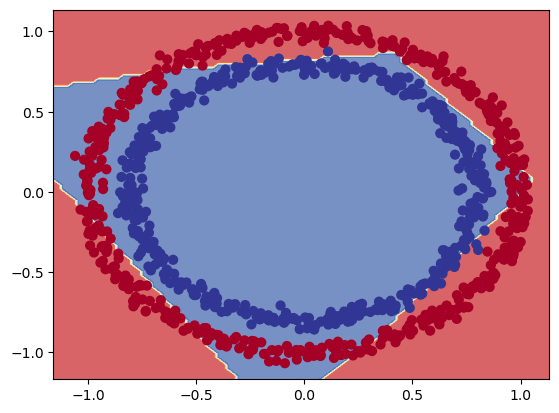

In [22]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_5, X, y)

It looks like our model is separating the two circles almost perfectlyalmost perfectly.

**Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here?


### Evaluating and improving our classification model

We've been evaluating our model on the same data it was trained on.
What we really should have done is to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set and then see how well it learned the patterns by using it to predict values on the test set.

In [23]:
# How many examples are in the whole dataset?
len(X)

1000

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples sould be in the training set, 200 examples in the test set

((800, 2), (200, 2))

Now we've got training and test sets, let's model the training data and evaluate what our model has learned on the test set.
This time, we will raise the learning_rate to 0.01 and train for only 25 epochs. Additionally, we will also pass X_test and y_test as `validation_data`.

In [26]:
# Set random seed
tf.random.set_seed(42)

# Create the model (same as model_7)
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
25/25 [==============================] - 1s 8ms/step - loss: 0.6986 - accuracy: 0.4625 - val_loss: 0.6931 - val_accuracy: 0.4700
Epoch 2/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5188 - val_loss: 0.6888 - val_accuracy: 0.5200
Epoch 3/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5437 - val_loss: 0.6833 - val_accuracy: 0.5300
Epoch 4/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5775 - val_loss: 0.6784 - val_accuracy: 0.5350
Epoch 5/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.5537 - val_loss: 0.6712 - val_accuracy: 0.5650
Epoch 6/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6400 - val_loss: 0.6576 - val_accuracy: 0.6050
Epoch 7/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6675 - val_loss: 0.6406 - val_accuracy: 0.6250
Epoch 8/25
25/25 [==

In [27]:
# Evaluate our model on the test set
loss, accuracy = model_6.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 1ms/step - loss: 0.4142 - accuracy: 0.8200
Model loss on the test set: 0.4141903817653656
Model accuracy on the test set: 82.00%


Again, let's visualize the results.

313/313 [==============================] - 0s 690us/step
doing binary classifcation...
313/313 [==============================] - 0s 670us/step
doing binary classifcation...


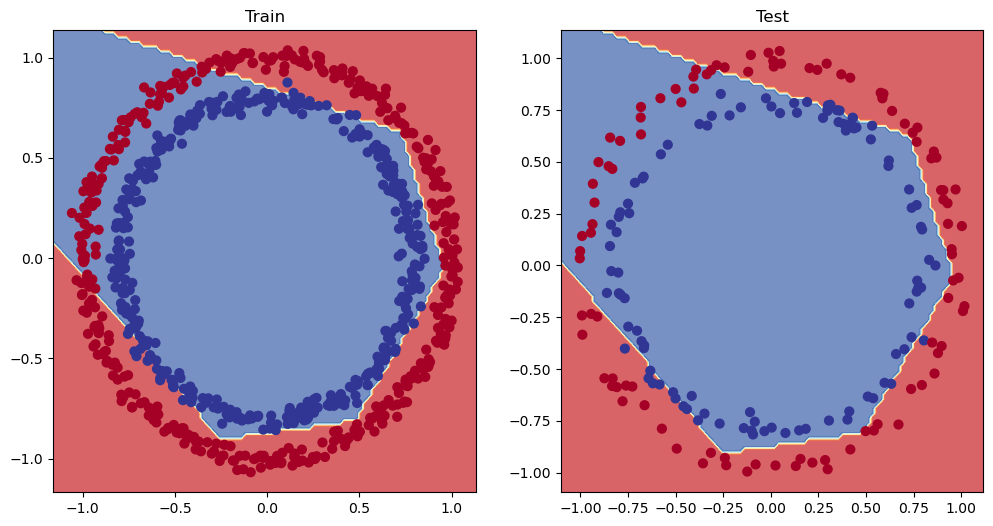

In [28]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, X=X_test, y=y_test)
plt.show()

With a few adaptions, our model is now predicting the blue and red circles almost perfectly.

### Plot the loss curves

Looking at the plots above, we can see the outputs of our model are very good.
But how did our model go whilst it was learning?

Let's plot the loss curves, just like we did with the regression problems.

In [29]:
# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.698637,0.46250,0.693097,0.470
1,0.688420,0.51875,0.688802,0.520
2,0.682426,0.54375,0.683294,0.530
3,0.675834,0.57750,0.678364,0.535
4,0.665861,0.55375,0.671225,0.565
5,0.651895,0.64000,0.657578,0.605
6,0.635444,0.66750,0.640577,0.625
7,0.610431,0.66500,0.615306,0.640
8,0.577271,0.71500,0.587425,0.705
9,0.544075,0.75750,0.556129,0.720


Text(0.5, 1.0, 'Model_6 training curves')

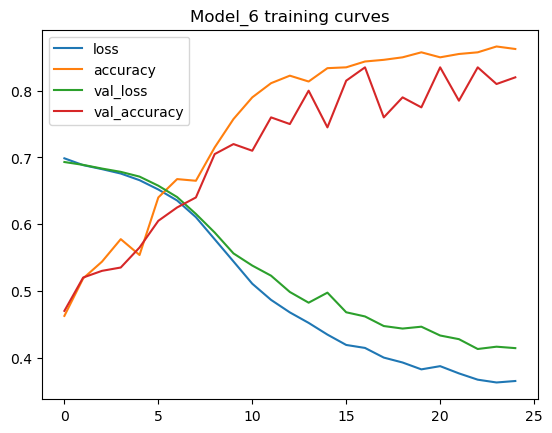

In [30]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_6 training curves")

This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up. We can also see, that the model ist not over- or underfitting, since the training and validation metrics are close together.

### Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important **hyperparameter** you can tune for your neural network models is the **learning rate**.

In `model_6` you saw we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01` and you might be wondering why.
With practice, you'll start to see what kind of hyperparameters work and what don't, although it is a good idea to start with the default values.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

However, there is a tool which can help to find the optimal learning rate.

We're going to use a [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).

**Remember:** A callback is an extra piece of functionality you can add to your model *while* its training.

In [31]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as model_6)
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_7.compile(loss="binary_crossentropy", # we can use strings here too
              optimizer="Adam", # same as tf.keras.optimizers.Adam() with default settings
              metrics=["accuracy"])

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

# Fit the model (passing the lr_scheduler callback)
history = model_7.fit(X_train,
                      y_train,
                      epochs=100,
                      callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 1s 2ms/step - loss: 0.7047 - accuracy: 0.4963 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7043 - accuracy: 0.4950 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7038 - accuracy: 0.4963 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7033 - accuracy: 0.4975 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7027 - accuracy: 0.4963 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7021 - accuracy: 0.4950 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.4913 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7008 - accuracy: 0.4913 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 9ms/step - loss:

Now our model has finished training, let's have a look at the training history.

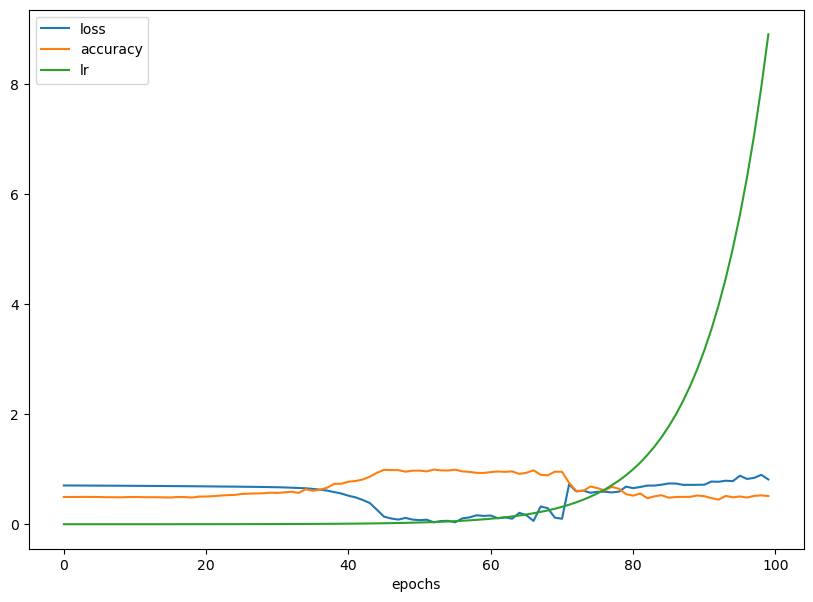

In [32]:
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

As you you see the learning rate exponentially increases as the number of epochs increases.

And you can see the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

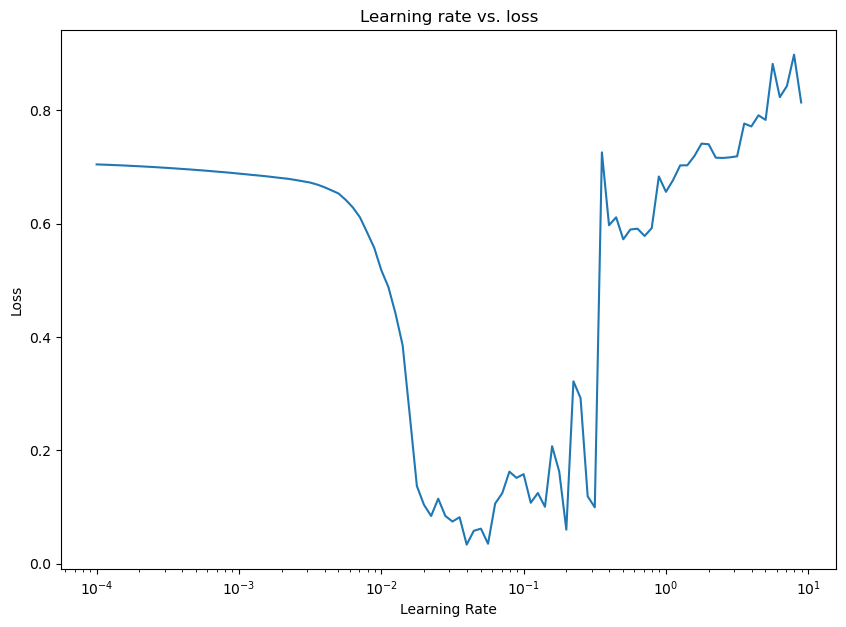

In [33]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

To determine the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite reached a minimum (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` and `0.02`.

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it with 20 epochs.

In [34]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model with the ideal learning rate
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # to adjust the learning rate, you need to use tf.keras.optimizers.Adam (not "adam")
                metrics=["accuracy"])

# Fit the model for 20 epochs (5 less than before)
history = model_8.fit(X_train, y_train, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 2ms/step - loss: 0.6868 - accuracy: 0.5525
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.5550
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6509 - accuracy: 0.6100
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6154 - accuracy: 0.6450
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7375
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4925 - accuracy: 0.7925
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.9300
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.2312 - accuracy: 0.9762
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9862
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1252 - accuracy: 0.9875
Epoch 11/20
25/25 [

In [35]:
# Evaluate model on the test dataset
model_8.evaluate(X_test, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.0512 - accuracy: 0.9950


[0.05123098939657211, 0.9950000047683716]

With a little higher learning rate (`0.02` instead of `0.01`) we reach a similar accuracy than `model_6` in less epochs (`20` instead of `25`).



Let's see how the predictions look.

313/313 [==============================] - 0s 714us/step
doing binary classifcation...
313/313 [==============================] - 0s 690us/step
doing binary classifcation...


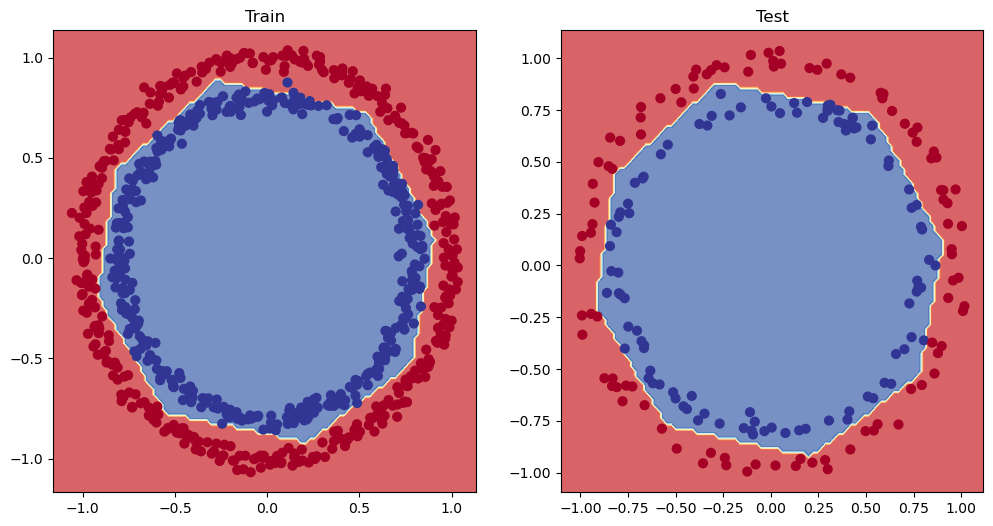

In [36]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

And as we can see, almost perfect again.
These are the kind of experiments you'll be running often when building your own models.
Start with default settings and see how they perform on your data.
And if they don't perform as well as you'd like, improve them.

### More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |


We can make a confusion matrix using [Scikit-Learn's `confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method.

In [37]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_preds = model_8.predict(X_test)

# Create confusion matrix
confusion_matrix(y_test, y_preds)

7/7 [==============================] - 0s 977us/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

It seems our predictions aren't in the format they need to be.
Let's see what we can do.

In [38]:
# View the first 10 predictions
y_preds[:10]

array([[9.9787199e-01],
       [3.4975186e-03],
       [9.9901223e-01],
       [9.8474808e-03],
       [9.2300761e-01],
       [9.6389681e-01],
       [5.1001261e-06],
       [2.0398150e-04],
       [9.9776042e-01],
       [1.3925054e-03]], dtype=float32)

What about our test labels?

In [39]:
# View the first 10 test labels
y_test[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

It looks like we need to get our predictions into the binary format (0 or 1). 
In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.
This is why a usual step after making predicitons with a neural network is converting the prediction probabilities into labels.
In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [40]:
# Convert prediction probabilities to binary format and view the first 10
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

Now we can use the `confusion_matrix` function.

In [41]:
# Create a confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

array([[100,   0],
       [  1,  99]])

We can see the highest numbers are down the diagonal (from top left to bottom right), which is a good sign. 

We could still improve on our confusion matrix, by using a ready-made function to visualise it.

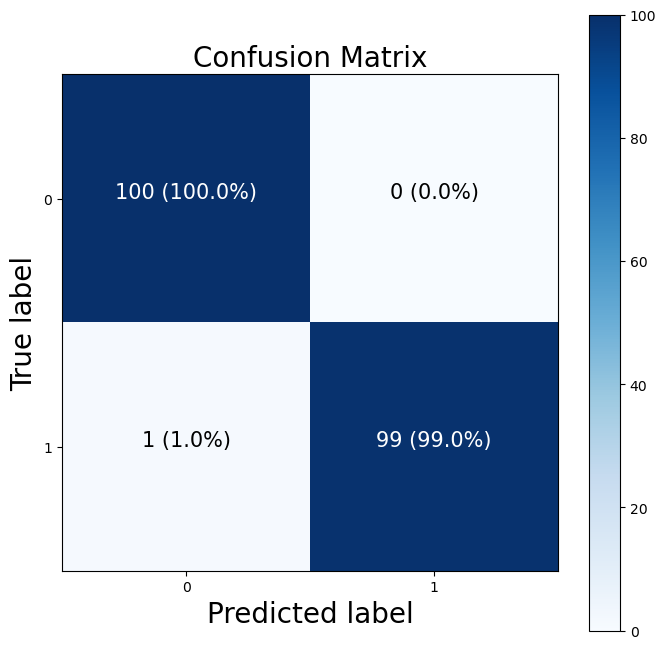

In [42]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools

figsize = (8, 8)

# Create the confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

Now, our confusion matrix is easy to interpret. It seems our model has made almost perfect predictions.